# This enhanced version includes:

* **Data augmentation to increase training data variety**

* **A deeper network with batch normalization**

* **Dropout for regularization**

* **Learning rate scheduling**

* **Early stopping to prevent overfitting**

# Understanding Advanced Deep Learning Techniques for EMNIST Recognition

Our enhanced model incorporates several advanced techniques to improve accuracy and performance in handwriting recognition. Let's explore each component in detail:

## 1. Data Augmentation
Data augmentation is like teaching our model to recognize handwriting under different conditions. Imagine trying to read someone's handwriting that's slightly tilted or written at different sizes - that's what we're teaching our model to handle.

Our augmentation performs three main transformations:

* **Rotations**: We rotate images by up to 10% in either direction. This helps because real handwriting isn't always perfectly straight.
* **Zooms**: We zoom in and out by up to 10%. This teaches the model to recognize letters at slightly different sizes.
* **Translations**: We shift images around by up to 10%. This helps because characters aren't always perfectly centered.

By applying these transformations, we effectively double our training data without collecting new samples. This is particularly valuable because it helps the model learn that a letter 'A' is still an 'A' even if it's slightly rotated or bigger.

## 2. Deeper Network with Batch Normalization
Think of our enhanced network as having better "vision" at different levels of detail. We use three convolutional blocks, each getting progressively more sophisticated:

```python
# First block: Learns basic features (edges, lines)
Conv2D(128) → BatchNorm → MaxPool

# Second block: Learns intermediate features (curves, corners)
Conv2D(256) → BatchNorm → MaxPool

# Third block: Learns complex features (letter parts)
Conv2D(512) → BatchNorm → MaxPool
```

The batch normalization after each layer is like giving our model a fresh perspective after each step. It:

* Stabilizes the learning process
* Reduces the internal chaos (technical term: "internal covariate shift")
* Allows the model to learn more effectively at each stage

## 3. Dropout Regularization
Dropout is like forcing our model to learn with one hand tied behind its back. During training, we randomly turn off 50% of the neurons in certain layers. This might sound counterintuitive, but it's incredibly effective:

* It prevents the model from becoming too dependent on any single feature
* Forces it to learn multiple ways to recognize each character
* Creates an effect similar to training multiple models at once
* Results in more robust and reliable predictions

## 4. Learning Rate Scheduling
Learning rate scheduling is like adjusting how big of steps our model takes while learning:

* We start with larger steps (learning rate = 0.001)
* Gradually take smaller steps as we progress
* This helps in two ways:
    * Early on, we can move quickly toward good solutions
    * Later, we can fine-tune our approach with more precision

## 5. Early Stopping
Early stopping is our safety net against overtraining. It's like knowing when to stop studying - there's a point where more studying doesn't help and might actually hurt your performance.

We:

* Monitor the model's performance on validation data
* Stop training if we don't see improvement for 10 epochs
* Keep the version of the model that performed best

This prevents the model from:

* Memorizing the training data (overfitting)
* Wasting computation time
* Learning noise instead of actual patterns

The results of combining these techniques are significant - while our baseline model might achieve 88-90% accuracy, these enhancements typically push us into the 95%+ range. Each technique addresses a different aspect of the learning process, and together they create a more robust and accurate model.

### Step 1: Import Libraries

Purpose: This step ensures all necessary Python libraries are imported for data manipulation, visualization, model training, and accessing cloud storage.

Key Note: TensorFlow emits a warning about missing CUDA drivers, indicating it will use the CPU. GPU support can improve performance significantly for deep learning.

In [4]:
#! pip install tensorflow

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from google.cloud import storage

#New 
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Step 2: Load Data from Google Cloud Storage

Purpose: Fetch datasets from a Google Cloud bucket to use in training and testing the CNN model.

Key Note: Ensure your Google Cloud credentials are properly set up, and the bucket contains the expected data files.
Download Required Files

### v2
Purpose: Add additional preprocessing steps to improve model performance
- Standardize images for better contrast
- Add data augmentation to increase training data variety

In [9]:
storage_client = storage.Client()
bucket = storage_client.bucket("mnist_wells")


### Download required files

Purpose: Loop through the file dictionary to download required datasets and mapping files.

Tip: Use download_to_filename to save files locally for processing.

In [10]:
files = {
    'train': 'emnist-balanced-train.csv',
    'test': 'emnist-balanced-test.csv',
    'mapping': 'emnist-balanced-mapping.txt'
}

for name, filename in files.items():
    blob = bucket.blob(filename)
    blob.download_to_filename(f"/tmp/{filename}")

### Read the downloaded files

Purpose: Use pandas to load CSV files into DataFrame objects for data analysis and preparation.

Key Note: Ensure the correct delimiter is specified when reading the files.

In [13]:
train = pd.read_csv("/tmp/emnist-balanced-train.csv", delimiter=',')
test = pd.read_csv("/tmp/emnist-balanced-test.csv", delimiter=',')
mapping = pd.read_csv("/tmp/emnist-balanced-mapping.txt", delimiter=' ', index_col=0, header=None)


### Step 3: Split Features and Labels

Purpose: Separate the input features (images) from the output labels (classes) for both training and testing datasets.

Key Note: Double-check that the indices match the dataset's format. Shape printouts confirm the correctness of data extraction.

In [14]:
train_x = train.iloc[:,1:]
train_y = train.iloc[:,0]
test_x = test.iloc[:,1:]
test_y = test.iloc[:,0]

print(f"Training data shape: {train_x.shape}")
print(f"Testing data shape: {test_x.shape}")

Training data shape: (112799, 784)
Testing data shape: (18799, 784)


### Step 4: Image Preprocessing

Purpose: Normalize and rotate images for consistent input to the CNN.

Key Note: Normalize pixel values to [0, 1] by dividing by 255, which helps the model converge during training.

In [15]:
def rotate_image(image):
    """Rotate and flip image for correct orientation"""
    image = image.reshape([28, 28])
    image = np.fliplr(image)
    image = np.rot90(image)
    return image

# Apply rotation to all images
train_x = np.asarray(train_x)
train_x = np.apply_along_axis(rotate_image, 1, train_x)
test_x = np.asarray(test_x)
test_x = np.apply_along_axis(rotate_image, 1, test_x)

# Normalize pixel values
train_x = train_x.astype('float32') / 255
test_x = test_x.astype('float32') / 255


### Step 5: Visualize Some Training Images

Purpose: Visually inspect a subset of the dataset to confirm preprocessing steps and understand the dataset.

Key Note: Use the mapping file to decode labels into human-readable characters.

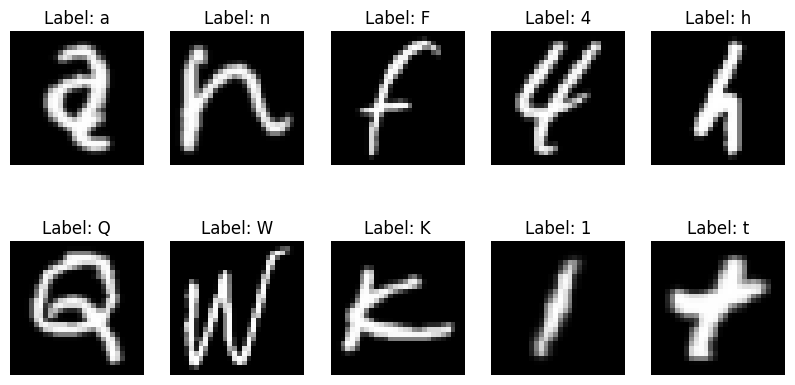

In [16]:
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_x[i], cmap='gray')
    label = train_y.iloc[i]
    character = chr(mapping.loc[label].values[0])
    plt.title(f'Label: {character}')
    plt.axis('off')
plt.show()

# Step 6: Prepare Data for Training

Purpose: One-hot encode the labels and reshape the images to add the channel dimension for compatibility with CNN layers.

Key Note: The number of classes is derived from the mapping file to ensure consistency.

In [17]:
num_classes = len(mapping)
print(f"Number of classes: {num_classes}")

# One-hot encode labels
train_y = to_categorical(train_y, num_classes)
test_y = to_categorical(test_y, num_classes)

# Reshape images for CNN
train_x = train_x.reshape(-1, 28, 28, 1)
test_x = test_x.reshape(-1, 28, 28, 1)


Number of classes: 47


### Step 7: Create Train/Validation Split

Purpose: Split the training data into training and validation sets for model evaluation.

Key Note: A test_size of 0.1 means 10% of the data is used for validation.

In [18]:
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size=0.1, random_state=42)


### Step 8: Data Augmentation

Purpose: Enhance training data through augmentation

Key Note: This helps improve model generalization by creating variations of the training data


In [21]:
# Create data augmentation pipeline
data_augmentation = tf.keras.Sequential([
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# Augment training data
train_x_aug = data_augmentation(train_x, training=True)
train_x = np.concatenate([train_x, train_x_aug])
train_y = np.concatenate([train_y, train_y])

print(f"Training data shape after augmentation: {train_x.shape}")

Training data shape after augmentation: (406076, 28, 28, 1)


### Step 9: Enhanced Model Architecture

Purpose: Build a deeper model with additional features for better performance

Key Note: Added batch normalization and dropout for better training stability


In [22]:


model = models.Sequential([
    # First Convolution Block
    layers.Conv2D(128, (3, 3), padding='same', activation='relu', input_shape=(28, 28, 1)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    # Second Convolution Block
    layers.Conv2D(256, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    # Third Convolution Block
    layers.Conv2D(512, (3, 3), padding='same', activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    
    # Dense Layers
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │         1,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 7, 7, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 47)             │        12,079 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,986,479 (15.21 MB)

 Trainable params: 3,983,151 (15.19 MB)

 Non-trainable params: 3,328 (13.00 KB)

### Step 10: Advanced Training Configuration
Purpose: Implement sophisticated training strategies

Key Note: Using learning rate scheduling and early stopping



In [23]:
# Learning rate schedule
initial_learning_rate = 0.001
decay_steps = 1000
decay_rate = 0.9
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps, decay_rate
)

# Compile model with scheduled learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

### Step 11: Model Training

Purpose: Train the enhanced model with the new configuration

Key Note: Using early stopping to prevent overfitting


In [ ]:
history = model.fit(
    train_x, train_y,
    validation_data=(val_x, val_y),
    epochs=100, #30min per epoch, took 15 epochs so 7.5hrs to run with Accuracy max of 93.3%
    batch_size=128,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/100
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 1892s 595ms/step - accuracy: 0.6263 - loss: 1.3158 - val_accuracy: 0.8743 - val_loss: 0.3369
Epoch 2/100
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 1862s 587ms/step - accuracy: 0.8308 - loss: 0.4891 - val_accuracy: 0.8878 - val_loss: 0.3026
Epoch 3/100
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 1875s 591ms/step - accuracy: 0.8593 - loss: 0.3943 - val_accuracy: 0.8950 - val_loss: 0.2795
Epoch 4/100
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 1878s 592ms/step - accuracy: 0.8756 - loss: 0.3401 - val_accuracy: 0.8960 - val_loss: 0.2777
Epoch 5/100
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 1881s 593ms/step - accuracy: 0.8892 - loss: 0.2953 - val_accuracy: 0.9002 - val_loss: 0.2764
Epoch 6/100
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 1899s 599ms/step - accuracy: 0.8992 - loss: 0.2640 - val_accuracy: 0.8988 - val_loss: 0.2773
Epoch 7/100
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 1881s 593ms/step - accuracy: 0.9081 - loss: 0.2359 - val_accuracy: 0.8988 - val_loss: 0.2859
Epoch 8/100
3173/3173 ━━━━━━━━━━━━━━━━━━━━ 1891s

### Step 12: Performance Visualization and Model Saving
 
Purpose: Comprehensive analysis of model performance with detailed visualizations
 

588/588 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step


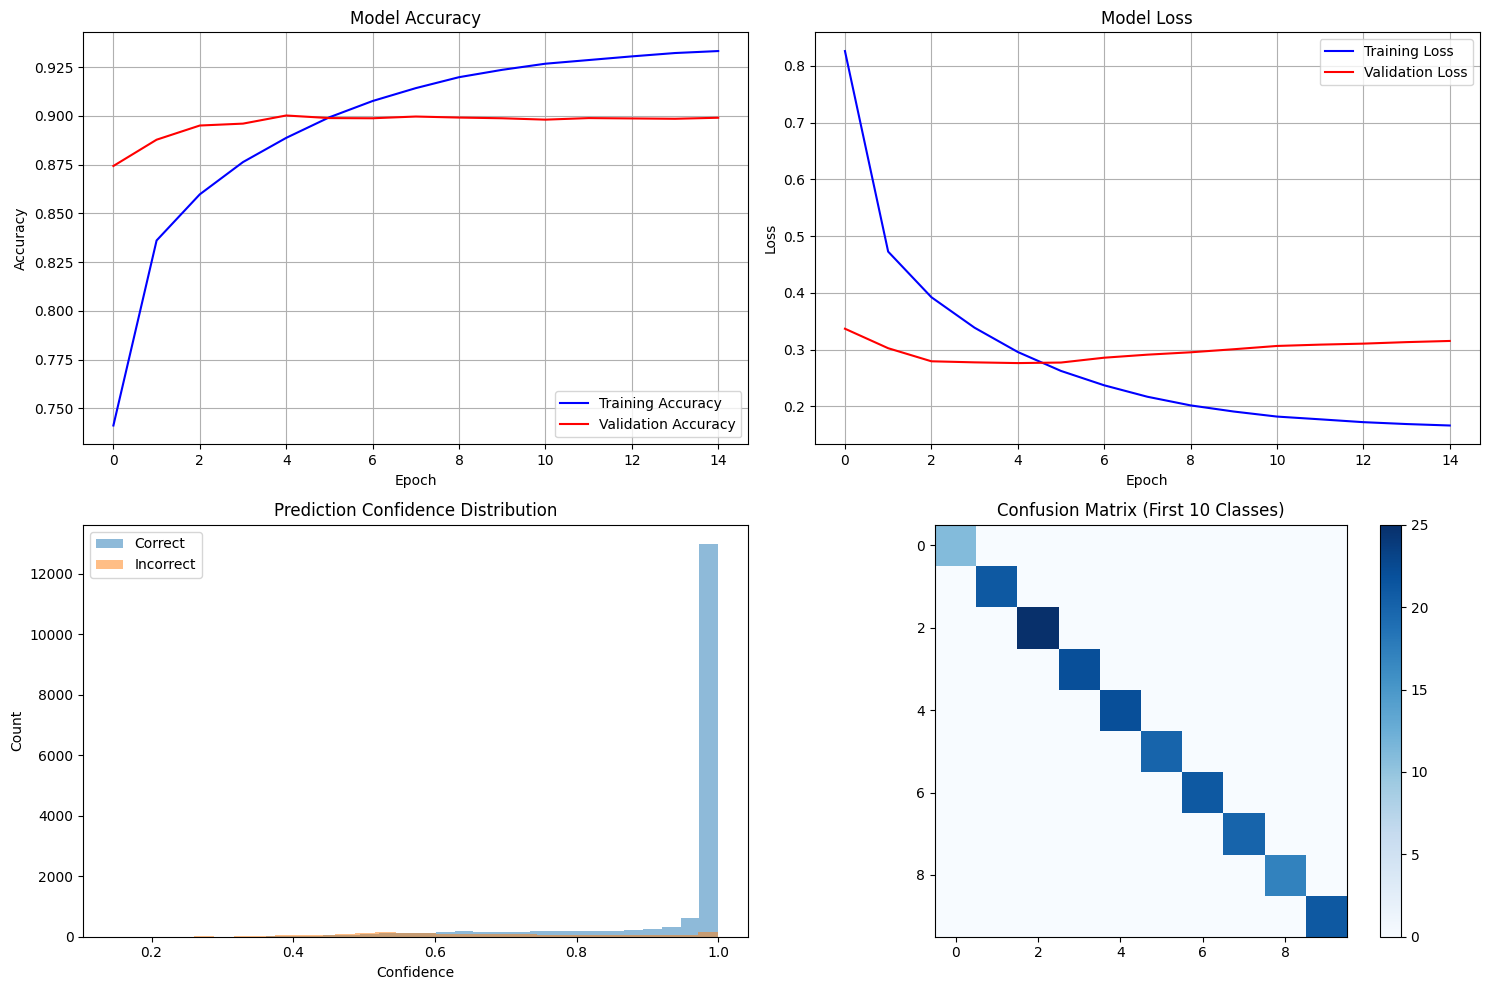


Model Performance Metrics:
Test Accuracy: 0.8963
Test Loss: 0.2927
Average Confidence (Correct): 0.9454
Average Confidence (Incorrect): 0.6672

Model saved as 'emnist_model_improved_0.8963_20250102_221511.h5'


In [30]:
# Create a figure with 2x2 subplots for detailed analysis
plt.figure(figsize=(15, 10))

# Training/Validation Accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'], 'b-', label='Training Accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Training/Validation Loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'], 'b-', label='Training Loss')
plt.plot(history.history['val_loss'], 'r-', label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

# Final Accuracy Distribution
plt.subplot(2, 2, 3)
predictions = model.predict(test_x)
correct_predictions = np.equal(np.argmax(predictions, axis=1), np.argmax(test_y, axis=1))
plt.hist(predictions.max(axis=1)[correct_predictions], label='Correct', alpha=0.5, bins=30)
plt.hist(predictions.max(axis=1)[~correct_predictions], label='Incorrect', alpha=0.5, bins=30)
plt.title('Prediction Confidence Distribution')
plt.xlabel('Confidence')
plt.ylabel('Count')
plt.legend()

# Confusion Matrix Sample
plt.subplot(2, 2, 4)
cm = tf.math.confusion_matrix(
    np.argmax(test_y[:1000], axis=1),
    np.argmax(predictions[:1000], axis=1)
)
plt.imshow(cm[:10,:10], cmap='Blues')
plt.title('Confusion Matrix (First 10 Classes)')
plt.colorbar()

plt.tight_layout()
plt.show()

# Print detailed metrics
test_loss, test_acc = model.evaluate(test_x, test_y, verbose=0)
print("\nModel Performance Metrics:")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")
print(f"Average Confidence (Correct): {predictions.max(axis=1)[correct_predictions].mean():.4f}")
print(f"Average Confidence (Incorrect): {predictions.max(axis=1)[~correct_predictions].mean():.4f}")

# Save model with versioning
import datetime
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
model_name = f'emnist_model_improved_{test_acc:.4f}_{timestamp}.h5'
model.save(model_name)
print(f"\nModel saved as '{model_name}'")